# Environment prep  

In [1]:
from numpy import where
from numpy import unique
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans, SpectralClustering,AgglomerativeClustering
from scipy.cluster.hierarchy import linkage,dendrogram
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn import model_selection
from sklearn import feature_selection
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder
from xgboost import XGBClassifier
from sklearn import svm, tree, linear_model, ensemble, neighbors
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

plt.style.use('ggplot')
sns.set_style('white')

# format control
pd.set_option('display.float_format', lambda x: '%.2f' % x)
# display all columns(features)
pd.set_option('display.max_columns', None)

# Data prep 

## data reading

In [2]:
data_train = pd.read_csv('QUB_Insurance_Data_Assignment_Training.csv')
data_score = pd.read_csv('QUB_Insurance_Data_Assignment_Scoring.csv')

data1 = data_train.copy(deep=True)

# data1.info()
# data1.sample(10)

data1_des = data1.describe()
data1_info = data1.info()

data1_des.to_excel('data1_des.xlsx', sheet_name='raw_des')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4090 entries, 0 to 4089
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   CustomerID              4090 non-null   int64  
 1   Title                   4090 non-null   object 
 2   GivenName               4090 non-null   object 
 3   MiddleInitial           4090 non-null   object 
 4   Surname                 4090 non-null   object 
 5   CreditCardType          3368 non-null   object 
 6   Occupation              2534 non-null   object 
 7   Gender                  4090 non-null   object 
 8   Age                     4090 non-null   int64  
 9   Location                4090 non-null   object 
 10  MotorInsurance          4090 non-null   object 
 11  MotorValue              3361 non-null   float64
 12  MotorType               3361 non-null   object 
 13  HealthInsurance         4090 non-null   object 
 14  HealthType              2543 non-null   

## pre-processing

### check NA values distribution

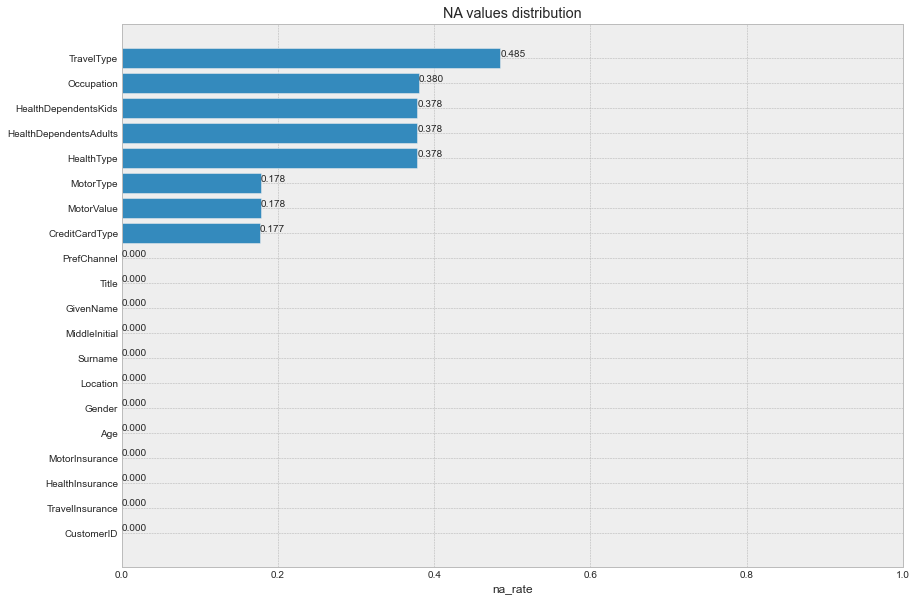

In [3]:
df = data1
na_rate = (len(df)-df.count())/len(df)  # 缺失率计算
a = na_rate.sort_values()
a1 = pd.DataFrame(a)
plt.style.use('bmh')
plt.figure(figsize = (14,10))
plt.barh(range(df.shape[1]),a1[0])
plt.xlabel('na_rate')
plt.xlim([0,1])
plt.title('NA values distribution')
plt.yticks(range(df.shape[1]),a1.index.values.tolist())
for x,y in enumerate(a1[0]):
    plt.text(y,x,'%.3f'%y, va='bottom')

In [4]:
data_dic = pd.read_excel('Data Dictionary.xlsx')  # ! the excel file has been pre-processed by removing row 1, col 1
data_dic.drop(data_dic.columns[0], inplace=True, axis=1)  # delete the raw index
data_dic['Non_Null'] = data1.count().values  # dataframe.count() - calculate non-null values of each columns, reutrn a series
data_dic

,Variable,Type,Len,Details,Non_Null
0,CustomerID,Num,8,A unique identifier for each customer,4090
1,Title,Char,4,NaN,4090
2,GivenName,Char,12,NaN,4090
3,MiddleInitial,Char,1,NaN,4090
4,Surname,Char,11,NaN,4090
5,CreditCardType,Char,10,The type of credit card held by the customer (...,3368
6,Occupation,Char,60,NaN,2534
7,Gender,Char,6,NaN,4090
8,Age,Num,8,NaN,4090
9,Location,Char,5,Indicates whether the customer lives in a Rura...,4090


### features classificaiton

In [5]:
features_ordinal = ['CustomerID']
features_categorical = ['Title', 'CreditCardType', 'MotorType', 'HealthType','TravelType']
features_binary = ['Gender','Location', 'MotorInsurance','HealthInsurance','TravelInsurance']
features_numeric = ['Age', 'MotorValue','HealthDependentsAdults','HealthDependentsKids']
features_textual = ['GivenName', 'MiddleInitial', 'Surname', 'Occupation']

### in-depth observation

1. check binary features

    results: 

    1. need to clean 'Gender' (f = female; m = male)

In [6]:
for feature in features_binary:
    print('-'*10 +' '+ feature + ' ' + '-'*10)
    print(data1[feature].value_counts(dropna=False))
    print('\n')


---------- Gender ----------
female    2063
male      2004
f           14
m            9
Name: Gender, dtype: int64


---------- Location ----------
Urban    2323
Rural    1767
Name: Location, dtype: int64


---------- MotorInsurance ----------
Yes    3361
No      729
Name: MotorInsurance, dtype: int64


---------- HealthInsurance ----------
Yes    2543
No     1547
Name: HealthInsurance, dtype: int64


---------- TravelInsurance ----------
Yes    2108
No     1982
Name: TravelInsurance, dtype: int64




2. check categorical features

    results: 
    
    1. need to figure the dependence of features (check error, eg: No TravelInsurance but have TravelType)

    2. need to clean NA values (or do encoding - onehotencoder)

In [7]:
for feature in features_categorical:
    print('-'*10 +' '+ feature + ' ' + '-'*10)
    print(data1[feature].value_counts(dropna=False))
    print('\n')

---------- Title ----------
Mr.     1950
Ms.     1064
Mrs.     949
Dr.      127
Name: Title, dtype: int64


---------- CreditCardType ----------
AMEX    1728
Visa    1640
NaN      722
Name: CreditCardType, dtype: int64


---------- MotorType ----------
Single    2287
Bundle    1074
NaN        729
Name: MotorType, dtype: int64


---------- HealthType ----------
NaN       1547
Level2    1254
Level1     662
Level3     627
Name: HealthType, dtype: int64


---------- TravelType ----------
NaN           1983
Business       668
Standard       477
Premium        442
Backpacker     336
Senior         184
Name: TravelType, dtype: int64




In [8]:
data1.loc[data1.MotorInsurance=='No', 'MotorValue'].value_counts(dropna=False)
# data1.loc[data1.MotorInsurance=='Yes', 'MotorValue'].count()

nan    729
Name: MotorValue, dtype: int64

In [9]:
data1.loc[data1.HealthInsurance=='No', 'HealthType'].value_counts(dropna=False)
data1.loc[data1.HealthInsurance=='Yes', 'HealthType'].value_counts(dropna=False)

Level2    1254
Level1     662
Level3     627
Name: HealthType, dtype: int64

In [13]:
data1.loc[data1.HealthInsurance=='No', 'HealthDependentsAdults'].value_counts(dropna=False)
data1.loc[data1.HealthInsurance=='Yes', 'HealthDependentsAdults'].value_counts(dropna=False)

1.00    1398
0.00     806
2.00     339
Name: HealthDependentsAdults, dtype: int64

In [14]:
data1.loc[data1.HealthInsurance=='No', 'HealthDependentsKids'].value_counts(dropna=False)
data1.loc[data1.HealthInsurance=='Yes', 'HealthDependentsAdults'].value_counts(dropna=False)

1.00    1398
0.00     806
2.00     339
Name: HealthDependentsAdults, dtype: int64

3. check numerical features

    results:

    1. need to clean error data - eg: Age -44 or 210; Motor Value -25686

    2. need to fill NA values (mean, median)
    
    3. need to segment Age/MotorValue 

In [15]:
data1[features_numeric].count()

Age                       4090
MotorValue                3361
HealthDependentsAdults    2543
HealthDependentsKids      2543
dtype: int64

In [16]:
data1[features_numeric].describe()

,Age,MotorValue,HealthDependentsAdults,HealthDependentsKids
count,4090.00,3361.00,2543.00,2543.00
mean,41.39,23450.91,0.82,1.75
std,15.99,11985.63,0.65,1.11
min,-44.00,-25686.00,0.00,0.00
25%,22.00,14837.00,0.00,0.00
50%,46.00,25045.00,1.00,2.00
75%,50.00,32289.00,1.00,3.00
max,210.00,325940.00,2.00,3.00


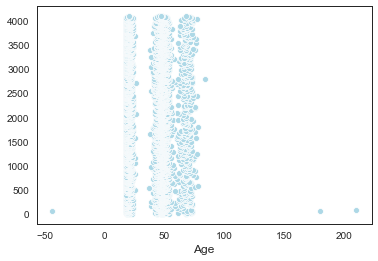

In [6]:
fig, ax = plt.subplots(1,1,figsize=(6, 4))
sns.scatterplot(x = 'Age',y=data1.index, data = data1, color = 'lightblue', ax = ax)

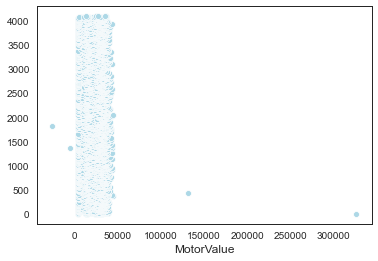

In [7]:
fig, ax = plt.subplots(1,1,figsize=(6, 4))
sns.scatterplot(x = 'MotorValue',y=data1.index, data = data1, color = 'lightblue', ax = ax)

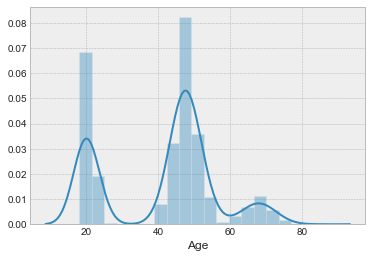

In [28]:
sns.distplot(data1.MotorValue)

### data cleaning 

In [32]:
data_cleaner = [data1, data_score]


for data in data_cleaner:
    
#     data.loc[data.Gender == 'f', 'Gender'] = 'female'
#     data.loc[data.Gender == 'm', 'Gender'] = 'male'
    data.Gender.replace('f', 'female', inplace = True)
    data.Gender.replace('m', 'male', inplace = True)  # These two methods are equivalent
    
    if 'PrefChannel' in data.columns: 
        data.PrefChannel.replace('P', 'Phone', inplace = True)
        data.PrefChannel.replace('E', 'Email', inplace = True)
        data.PrefChannel.replace('S', 'SMS', inplace = True)

    data.loc[(data.Age <= 0) | (data.Age >= 100), 'Age'] = data.Age.mean()
    
    data.loc[data.MotorValue < np.nanpercentile(data.MotorValue, 1), 'MotorValue'] = int(np.nanpercentile(data.MotorValue, 1))
    data.loc[data.MotorValue > np.nanpercentile(data.MotorValue, 99), 'MotorValue'] = int(np.nanpercentile(data.MotorValue, 99))

# data1.Gender.value_counts()
# data.Age.describe()

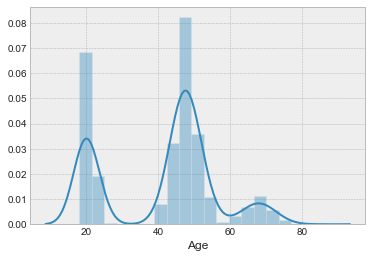

In [30]:
sns.distplot(data1.Age)

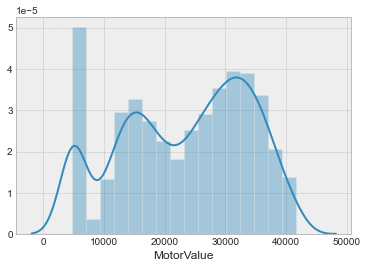

In [29]:
sns.distplot(data1.MotorValue)

In [31]:
data1.describe()
data_score

,CustomerID,Title,GivenName,MiddleInitial,Surname,CreditCardType,Occupation,Gender,Age,Location,MotorInsurance,MotorValue,MotorType,HealthInsurance,HealthType,HealthDependentsAdults,HealthDependentsKids,TravelInsurance,TravelType
0,3,Mr.,Niall,T,Graham,AMEX,Biophysicist,male,52.00,Urban,Yes,17274.00,Single,No,NaN,nan,nan,No,NaN
1,6,Mr.,Harry,L,McDonald,AMEX,Stevedore,male,49.00,Rural,Yes,11735.00,Single,Yes,Level1,2.00,3.00,Yes,Business
2,7,Dr.,Chanelle,L,Hay,AMEX,NaN,female,18.00,Urban,Yes,4884.00,Bundle,No,NaN,nan,nan,Yes,Backpacker
3,8,Ms.,Alexandra,J,Ross,AMEX,NaN,female,48.00,Urban,Yes,13879.00,Single,Yes,Level1,1.00,3.00,No,NaN
4,9,Mr.,Bailey,T,Atkinson,NaN,NaN,male,49.00,Rural,Yes,17294.00,Single,Yes,Level2,1.00,3.00,Yes,Standard
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1086,5169,Mrs.,Eleanor,D,Bennett,AMEX,Medical laboratory technician,female,18.00,Rural,Yes,30271.00,Bundle,No,NaN,nan,nan,Yes,Premium
1087,5176,Mrs.,Rebecca,P,Milne,Visa,NaN,female,51.00,Urban,Yes,10999.00,Single,Yes,Level1,0.00,3.00,Yes,Standard
1088,5177,Mr.,Billy,C,Riley,Visa,En route controller,male,52.00,Rural,Yes,16622.00,Single,Yes,Level2,0.00,2.00,No,NaN
1089,5179,Mr.,Russell,C,Shaw,Visa,Dipper,male,47.00,Rural,Yes,11277.00,Single,No,NaN,nan,nan,No,NaN


# Feature engineering 

### feature transformation

for continuous variables like 'Age', we use cut to allocate data

In [12]:
for data in data_cleaner:
    data['AgeBin'] = pd.cut(data['Age'].astype(int), 3)  # cut Age as 3 bins
    
    data['MotorValue_fillmean'] = data['MotorValue'].values
    data['MotorValue_fillmean'].fillna(data['MotorValue_fillmean'].mean(), inplace = True)
    
    data['MotorValue'].fillna(999999, inplace=True)
    data['MotorValueBin'] = pd.cut(data['MotorValue'], [4683.137, 12092.6, 19465.2,26837.8,34210.4,1000000])

In [34]:
# data1.info()
data1.Gender.value_counts()

female    2077
male      2013
Name: Gender, dtype: int64

fill NA with 'NoData', and do one-hot encoding, then delete 'NoData' column.

In [13]:
for data in data_cleaner:
    data['CreditCardType'].fillna('NoData', inplace=True)
    data['MotorValue'].fillna('NoData', inplace=True)
    data['MotorType'].fillna('NoData', inplace=True)
    data['HealthType'].fillna('NoData', inplace=True)
    data['HealthDependentsAdults'].fillna('NoData', inplace=True)
    data['HealthDependentsKids'].fillna('NoData', inplace=True)
    data['TravelType'].fillna('NoData', inplace=True)
# data1.info()

In [33]:
data1.to_csv('data_train_cleaned.csv', encoding='utf-8-sig')

too few value '1.00' in 'HealthDependentsKids', change them into '2.00'

In [37]:
data1.HealthDependentsKids.value_counts()

NoData    1547
2.0       1203
3.0        674
0.0        648
1.0         18
Name: HealthDependentsKids, dtype: int64

In [14]:
for data in data_cleaner:
    data.loc[data.HealthDependentsKids == 1, 'HealthDependentsKids'] = 2

In [39]:
data1.HealthDependentsKids.value_counts()

NoData    1547
2.0       1221
3.0        674
0.0        648
Name: HealthDependentsKids, dtype: int64

In [27]:
data1.TravelType.value_counts()

NoData        1983
Business       668
Standard       477
Premium        442
Backpacker     336
Senior         184
Name: TravelType, dtype: int64

### feature encoding and feature selection

In [15]:
label = LabelEncoder()

data1['AgeBin_Code'] = label.fit_transform(data1['AgeBin'])
# data1['MotorValueBin_Code'] = label.fit_transform(data1['MotorValueBin'])
data1['Gender_Code'] = label.fit_transform(data1['Gender'])
data1['MotorInsurance_Code'] = label.fit_transform(data1['MotorInsurance'])
data1['HealthInsurance_Code'] = label.fit_transform(data1['HealthInsurance'])
data1['TravelInsurance_Code'] = label.fit_transform(data1['TravelInsurance'])

dummy_x = ['CreditCardType','HealthDependentsAdults','HealthDependentsKids', 'Title', 'Gender', 'Location', 'MotorValueBin',  'MotorType','HealthType', 'TravelType']
x = pd.get_dummies(data1[dummy_x])
data1_encoding = pd.concat([data1, x], axis=1)

In [16]:
label = LabelEncoder()

data_score['AgeBin_Code'] = label.fit_transform(data_score['AgeBin'])
# data_score['MotorValueBin_Code'] = label.fit_transform(data_score['MotorValueBin'])
data_score['Gender_Code'] = label.fit_transform(data_score['Gender'])

data_score['MotorInsurance_Code'] = label.fit_transform(data_score['MotorInsurance'])
data_score['HealthInsurance_Code'] = label.fit_transform(data_score['HealthInsurance'])
data_score['TravelInsurance_Code'] = label.fit_transform(data_score['TravelInsurance'])

dummy_x = ['CreditCardType','HealthDependentsAdults','HealthDependentsKids', 'Title', 'Gender', 'Location','MotorValueBin', 'MotorType','HealthType', 'TravelType']
x = pd.get_dummies(data_score[dummy_x])
data_score_encoding = pd.concat([data_score, x], axis=1)

Adjust feature names

In [17]:
for data in [data1_encoding, data_score_encoding]:
    data['MotorValueBin_1'] = data['MotorValueBin_(4683.137, 12092.6]']
    data['MotorValueBin_2'] = data['MotorValueBin_(12092.6, 19465.2]']    
    data['MotorValueBin_3'] = data['MotorValueBin_(19465.2, 26837.8]']    
    data['MotorValueBin_4'] = data['MotorValueBin_(26837.8, 34210.4]']    

In [19]:
# data1.columns.to_list()
data_x = [ 
 'Title_Dr.',
 'Title_Mr.',
 'Title_Mrs.',
 'Title_Ms.',
 'CreditCardType_AMEX',
 'CreditCardType_Visa',
 'Gender_female',
 'Gender_male',
 'AgeBin_Code',
 'Location_Rural',
 'Location_Urban',
 'MotorInsurance_Code',
 'HealthInsurance_Code',
 'TravelInsurance_Code',
 'MotorValueBin_1',
 'MotorValueBin_2',
 'MotorValueBin_3',
 'MotorValueBin_4',
 'MotorType_Bundle',
 'MotorType_Single',
 'HealthType_Level1',
 'HealthType_Level2',
 'HealthType_Level3',
 'HealthDependentsAdults_0.0',
 'HealthDependentsAdults_1.0',
 'HealthDependentsAdults_2.0',
 'HealthDependentsKids_0.0',
 'HealthDependentsKids_2.0',
 'HealthDependentsKids_3.0',
 'TravelType_Backpacker',
 'TravelType_Business',
 'TravelType_Premium',
 'TravelType_Senior',
 'TravelType_Standard'
]
# data1_encoding[data_x].info()
# data_score_encoding[data_x].info()
len(data_x)

34

In [44]:
data1_encoding[data_x].to_csv('train_encoding.csv', encoding = 'utf-8-sig')
data_score_encoding[data_x].to_csv('test_encoding.csv', encoding = 'utf-8-sig')

###  correlation analysis

In [33]:
def correlation_heatmap(df):
    _ , ax = plt.subplots(figsize =(30, 30))
    colormap = sns.diverging_palette(220, 10, as_cmap = True)
    
    _ = sns.heatmap(
        df.corr(), 
        cmap = colormap,
        square=True, 
        cbar_kws={'shrink':.9 }, 
        ax=ax,
        annot=True, 
        linewidths=0.1,vmax=1.0, linecolor='white',
        annot_kws={'fontsize':12 }
    )
    
    plt.title('Pearson Correlation of Features', y=1.05, size=15)

# correlation_heatmap(data_encoding)

# Modelling - Classification

## check data 

Now we have 
1. [data1, data_score] as cleaned dataset with raw columns
2. [data_encoding]

## Model set

In [18]:
MLA = [

#         ensemble.AdaBoostClassifier(),

#         ensemble.RandomForestClassifier(),

#         neighbors.KNeighborsClassifier(),

        svm.SVC(probability=True),  # Best one.

#         tree.DecisionTreeClassifier(),

#         XGBClassifier()

]

## Modelling

In [20]:
data_x = [
    'Title_Dr.',
    'Title_Mr.',
    'Title_Mrs.',
    'Title_Ms.',
    'CreditCardType_AMEX',
    'CreditCardType_Visa',
    #  'Gender_female',
    #  'Gender_male',
    'Gender_Code',
    'AgeBin_Code',
    'Location_Rural',
    'Location_Urban',
    'MotorInsurance_Code',
    #  'HealthInsurance_Code',
    #  'TravelInsurance_Code',

    'MotorValueBin_1',
    'MotorValueBin_2',
    'MotorValueBin_3',
    'MotorValueBin_4',

    #  'MotorType_Bundle',
    #  'MotorType_Single',
    #  'HealthType_Level1',
    #  'HealthType_Level2',
    #  'HealthType_Level3',
    'HealthDependentsAdults_0.0',
    'HealthDependentsAdults_1.0',
    'HealthDependentsAdults_2.0',
    'HealthDependentsKids_0.0',
    'HealthDependentsKids_2.0',
    'HealthDependentsKids_3.0',
    #  'TravelType_Backpacker',
    #  'TravelType_Business',
    #  'TravelType_Premium',
    #  'TravelType_Senior',
    #  'TravelType_Standard'
]

手动特征选择：
关键特征:
'MotorInsurance_Code'
'MotorValueBin',
'AgeBin_Code',


In [20]:
# run model 10x with 60/30 split intentionally leaving out 10%
cv_split = model_selection.ShuffleSplit(n_splits = 10, test_size = .3, train_size = .6, random_state = 0 ) 

#create table to compare MLA algorithms
MLA_columns = ['MLA Name', 'MLA Parameters','MLA Test Accuracy Mean']
MLA_compare = pd.DataFrame(columns = MLA_columns)

#create table to compare modeling results(y)
MLA_predict = pd.DataFrame()
MLA_predict['Target'] = data1['PrefChannel'].copy(deep=True)

#index through MLA and save performance to table
row_index = 0
for alg in MLA:

    MLA_name = alg.__class__.__name__ # 获取算法名称
    MLA_compare.loc[row_index, 'MLA Name'] = MLA_name
    MLA_compare.loc[row_index, 'MLA Parameters'] = str(alg.get_params())  # 获取算法参数
    cv_results = model_selection.cross_validate(alg, data1_encoding[data_x], data1.PrefChannel, cv  = cv_split)
    MLA_compare.loc[row_index, 'MLA Test Accuracy Mean'] = cv_results['test_score'].mean()   

    alg.fit(data1_encoding[data_x], data1.PrefChannel)
    MLA_predict[str(MLA_name)] = alg.predict(data1_encoding[data_x])
    
    row_index += 1

MLA_compare.sort_values(by = ['MLA Test Accuracy Mean'], ascending = False, inplace = True)
MLA_compare

,MLA Name,MLA Parameters,MLA Test Accuracy Mean
0,SVC,"{'C': 1.0, 'break_ties': False, 'cache_size': ...",0.66


In [21]:
for alg in MLA:
    data_score_encoding['Predict'] = alg.predict(data_score_encoding[data_x])

,CustomerID,Title,GivenName,MiddleInitial,Surname,CreditCardType,Occupation,Gender,Age,Location,MotorInsurance,MotorValue,MotorType,HealthInsurance,HealthType,HealthDependentsAdults,HealthDependentsKids,TravelInsurance,TravelType,AgeBin,MotorValue_fillmean,MotorValueBin,AgeBin_Code,Gender_Code,MotorInsurance_Code,HealthInsurance_Code,TravelInsurance_Code,CreditCardType_AMEX,CreditCardType_NoData,CreditCardType_Visa,HealthDependentsAdults_0.0,HealthDependentsAdults_1.0,HealthDependentsAdults_2.0,HealthDependentsAdults_NoData,HealthDependentsKids_0.0,HealthDependentsKids_2.0,HealthDependentsKids_3.0,HealthDependentsKids_NoData,Title_Dr.,Title_Mr.,Title_Mrs.,Title_Ms.,Gender_female,Gender_male,Location_Rural,Location_Urban,"MotorValueBin_(4683.137, 12092.6]","MotorValueBin_(12092.6, 19465.2]","MotorValueBin_(19465.2, 26837.8]","MotorValueBin_(26837.8, 34210.4]","MotorValueBin_(34210.4, 1000000.0]",MotorType_Bundle,MotorType_NoData,MotorType_Single,HealthType_Level1,HealthType_Level2,HealthType_Level3,HealthType_NoData,TravelType_Backpacker,TravelType_Business,TravelType_NoData,TravelType_Premium,TravelType_Senior,TravelType_Standard,MotorValueBin_1,MotorValueBin_2,MotorValueBin_3,MotorValueBin_4,Predict
0,3,Mr.,Niall,T,Graham,AMEX,Biophysicist,male,52.00,Urban,Yes,17274.00,Single,No,NoData,NoData,NoData,No,NoData,"(37.667, 57.333]",17274.00,"(12092.6, 19465.2]",1,1,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,Phone
1,6,Mr.,Harry,L,McDonald,AMEX,Stevedore,male,49.00,Rural,Yes,11735.00,Single,Yes,Level1,2.00,3.00,Yes,Business,"(37.667, 57.333]",11735.00,"(4683.137, 12092.6]",1,1,1,1,1,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,1,0,1,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,Phone
2,7,Dr.,Chanelle,L,Hay,AMEX,NaN,female,18.00,Urban,Yes,4884.00,Bundle,No,NoData,NoData,NoData,Yes,Backpacker,"(17.941, 37.667]",4884.00,"(4683.137, 12092.6]",0,0,1,0,1,1,0,0,0,0,0,1,0,0,0,1,1,0,0,0,1,0,0,1,1,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,SMS
3,8,Ms.,Alexandra,J,Ross,AMEX,NaN,female,48.00,Urban,Yes,13879.00,Single,Yes,Level1,1.00,3.00,No,NoData,"(37.667, 57.333]",13879.00,"(12092.6, 19465.2]",1,0,1,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,1,0,0,1,0,1,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,1,0,0,Phone
4,9,Mr.,Bailey,T,Atkinson,NoData,NaN,male,49.00,Rural,Yes,17294.00,Single,Yes,Level2,1.00,3.00,Yes,Standard,"(37.667, 57.333]",17294.00,"(12092.6, 19465.2]",1,1,1,1,1,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,1,0,0,Phone
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1086,5169,Mrs.,Eleanor,D,Bennett,AMEX,Medical laboratory technician,female,18.00,Rural,Yes,30271.00,Bundle,No,NoData,NoData,NoData,Yes,Premium,"(17.941, 37.667]",30271.00,"(26837.8, 34210.4]",0,0,1,0,1,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,Email
1087,5176,Mrs.,Rebecca,P,Milne,Visa,NaN,female,51.00,Urban,Yes,10999.00,Single,Yes,Level1,0.00,3.00,Yes,Standard,"(37.667, 57.333]",10999.00,"(4683.137, 12092.6]",1,0,1,1,1,0,0,1,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,1,0,0,0,Phone
1088,5177,Mr.,Billy,C,Riley,Visa,En route controller,male,52.00,Rural,Yes,16622.00,Single,Yes,Level2,0.00,2.00,No,NoData,"(37.667, 57.333]",16622.00,"(12092.6, 19465.2]",1,1,1,1,0,0,0,1,1,0,0,0,0,1,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,Phone
1089,5179,Mr.,Russell,C,Shaw,Visa,Dipper,male,47.00,Rural,Yes,11277.00,Single,No,NoData,NoData,NoData,No,NoData,"(37.667, 57.333]",11277.00,"(4683.137, 12092.6]",1,1,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,1,1,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,Phone


In [1]:
data1_encoding.PrefChannel.value_counts()

NameError: name 'data1_encoding' is not defined

## Model Comparasion Visulization 

Text(0, 0.5, 'Algorithm')

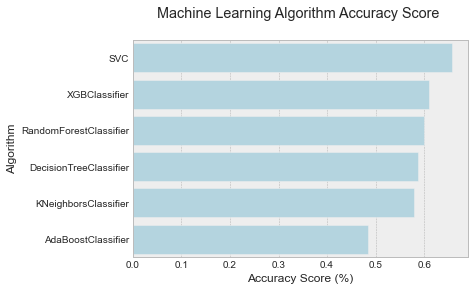

In [53]:
sns.barplot(x='MLA Test Accuracy Mean', y='MLA Name',
            data=MLA_compare, color='lightblue')

plt.title('Machine Learning Algorithm Accuracy Score \n')
plt.xlabel('Accuracy Score (%)')
plt.ylabel('Algorithm')

## Tuning - RandomForest

In [39]:
# RF = ensemble.RandomForestClassifier()
# base_results = model_selection.cross_validate(RF, data1_encoding[data_x], data1.PrefChannel, cv  = cv_split)
# RF.fit(data1_encoding[data_x], data1.PrefChannel)
# print('BEFORE Parameters: ', RF.get_params())
# print("BEFORE Test score mean: {:.2f}". format(base_results['test_score'].mean()*100))
# print('-'*10)

# param_grid = {
#             #RandomForestClassifier - http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier
#             'n_estimators': [10, 50, 100, 300], #default=10
#             'criterion': ['gini', 'entropy'], #default=”gini”
#             'max_depth': [2, 4, 6, 8, 10, None], #default=None
#             'oob_score': [True], #default=False -- 12/31/17 set to reduce runtime -- The best parameter for RandomForestClassifier is {'criterion': 'entropy', 'max_depth': 6, 'n_estimators': 100, 'oob_score': True, 'random_state': 0} with a runtime of 146.35 seconds.
#             'random_state': [0]
# }

# tune_model = model_selection.GridSearchCV(ensemble.RandomForestClassifier(), param_grid=param_grid, cv=cv_split)
# print('Tunning..')
# tune_model.fit(data1_encoding[data_x], data1.PrefChannel)
# print(tune_model.cv_results_.keys())
# print('AFTER Parameters: ', tune_model.best_params_)
# print("AFTER Test score mean: {:.2f}". format(tune_model.cv_results_['mean_test_score'][tune_model.best_index_]*100))
# print('-'*10)

## Tuning - SVC 

In [40]:
# SVC = svm.SVC()
# base_results = model_selection.cross_validate(SVC, data1_encoding[data_x], data1.PrefChannel, cv  = cv_split)
# SVC.fit(data1_encoding[data_x], data1.PrefChannel)
# print('BEFORE Parameters: ', SVC.get_params())
# print("BEFORE Test score mean: {:.2f}". format(base_results['test_score'].mean()*100))
# print('-'*10)

# param_grid = {
#     # SVC - http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC
#     'C': [1,2,3,4,5], #default=1.0
#     'decision_function_shape': ['ovo', 'ovr'], #default:ovr
# }

# tune_model = model_selection.GridSearchCV(svm.SVC(), param_grid=param_grid, cv=cv_split)
# print('Tunning..')
# tune_model.fit(data1_encoding[data_x], data1.PrefChannel)
# print(tune_model.cv_results_.keys())
# print('AFTER Parameters: ', tune_model.best_params_)
# print("AFTER Test score mean: {:.2f}". format(tune_model.cv_results_['mean_test_score'][tune_model.best_index_]*100))
# print('-'*10)

## Tuning - XGboost

In [41]:
# xgb = XGBClassifier()
# base_results = model_selection.cross_validate(xgb, data1_encoding[data_x], data1.PrefChannel, cv  = cv_split)
# xgb.fit(data1_encoding[data_x], data1.PrefChannel)
# print('BEFORE Parameters: ', xgb.get_params())
# print("BEFORE Test score mean: {:.2f}". format(base_results['test_score'].mean()*100))
# print('-'*10)

# param_grid = {
#             # XGBClassifier - http://xgboost.readthedocs.io/en/latest/parameter.html
#             'learning_rate': [.01, .03, .05, .1, .25], #default: .3
#             'max_depth': [1,2,4,6,8,10], #default 2
#             'n_estimators': [10, 50, 100, 300], 
#             'seed': [0]
# }

# tune_model = model_selection.GridSearchCV(XGBClassifier(), param_grid=param_grid, cv=cv_split)
# print('Tunning..')
# tune_model.fit(data1_encoding[data_x], data1.PrefChannel)
# print(tune_model.cv_results_.keys())
# print('AFTER Parameters: ', tune_model.best_params_)
# print("AFTER Test score mean: {:.2f}". format(tune_model.cv_results_['mean_test_score'][tune_model.best_index_]*100))
# print('-'*10)

# Modelling - Clustering

## Data Scaling 

In [21]:
data_cluster_x = ['Age', 'MotorValue_fillmean']
data = data1[data_cluster_x]

scaler = StandardScaler()
scaler.fit(data)
data = scaler.transform(data)

## Cluster model comparision 

### SpectralClustering

In [43]:
# cluster_model = SpectralClustering(n_clusters=5)
# cluster_model.fit(data)
# yhat = cluster_model.fit_predict(data)
# clusters = unique(yhat)
# for cluster in clusters:
#     row_ix = where(yhat == cluster)
#     plt.scatter(data[row_ix, 1], data[row_ix, 0])

# plt.title('Spectral (n = 5)')
# plt.xlabel('MotorValue')
# plt.ylabel('Age')

# plt.show()

### K-means 

#### n = 5 

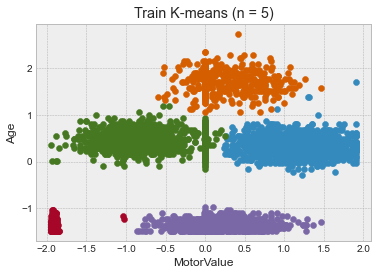

calinski_harabasz_score: 9873.680698774484
silhouette_score: 0.6724885581398462


0.6724885581398462

In [23]:
cluster_model = KMeans(n_clusters=5, random_state=9)
cluster_model.fit(data)
yhat = cluster_model.predict(data)
clusters = unique(yhat)

clusters_id = [] # Store different cluster ids

for cluster in clusters:
    row_ix = where(yhat == cluster)
    clusters_id.append(row_ix[0])  
    plt.scatter(data[row_ix, 1], data[row_ix, 0])

plt.title('Train K-means (n = 5)')
plt.xlabel('MotorValue')
plt.ylabel('Age')

plt.show()

print('calinski_harabasz_score:', metrics.calinski_harabasz_score(data, yhat))
print('silhouette_score:', silhouette_score(data, yhat))  
# cluster_model.cluster_centers_
from sklearn.metrics import silhouette_score 
score = silhouette_score(data, yhat)
score


In [45]:
cluster_x = ['CreditCardType', 'Age', 'Gender', 'Location', 
             'MotorInsurance', 'MotorValue', 
             'HealthInsurance', 'TravelInsurance', 
             'PrefChannel']

# data1_encoding.iloc[clusters_id[0],][cluster_x].to_csv('data_train_cluster_1.csv', encoding='utf-8-sig') # cluster 1
# data1_encoding.iloc[clusters_id[1],][cluster_x].to_csv('data_train_cluster_2.csv', encoding='utf-8-sig') # cluster 2
# data1_encoding.iloc[clusters_id[2],][cluster_x].to_csv('data_train_cluster_3.csv', encoding='utf-8-sig') # cluster 3
# data1_encoding.iloc[clusters_id[3],][cluster_x].to_csv('data_train_cluster_4.csv', encoding='utf-8-sig') # cluster 4
# data1_encoding.iloc[clusters_id[4],][cluster_x].to_csv('data_train_cluster_5.csv', encoding='utf-8-sig') # cluster 5


#### n = 4 

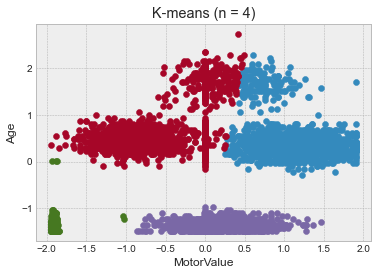

6400.436256659418


0.6072641153888834

In [26]:
cluster_model = KMeans(n_clusters=4, random_state=9)
cluster_model.fit(data)
yhat = cluster_model.predict(data)
clusters = unique(yhat)
for cluster in clusters:
    row_ix = where(yhat == cluster)
    plt.scatter(data[row_ix, 1], data[row_ix, 0])

plt.title('K-means (n = 4)')
plt.xlabel('MotorValue')
plt.ylabel('Age')

plt.show()

print(metrics.calinski_harabasz_score(data, yhat))
cluster_model.cluster_centers_

from sklearn.metrics import silhouette_score 
score = silhouette_score(data, yhat)
score

#### n = 3 

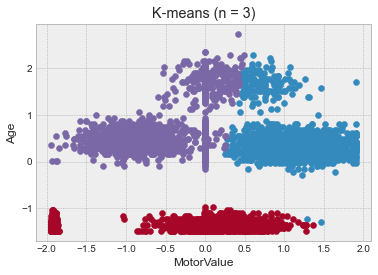

4544.496360211135


0.5205340213778804

In [25]:
cluster_model = KMeans(n_clusters=3, random_state=9)
cluster_model.fit(data)
yhat = cluster_model.predict(data)
clusters = unique(yhat)
for cluster in clusters:
    row_ix = where(yhat == cluster)
    plt.scatter(data[row_ix, 1], data[row_ix, 0])

plt.title('K-means (n = 3)')
plt.xlabel('MotorValue')
plt.ylabel('Age')

plt.show()

print(metrics.calinski_harabasz_score(data, yhat))
cluster_model.cluster_centers_

from sklearn.metrics import silhouette_score 
score = silhouette_score(data, yhat)
score


### GaussianMixture

In [48]:
# cluster_model = GaussianMixture(n_components=5, random_state=0)
# cluster_model.fit(data)
# yhat = cluster_model.predict(data)
# clusters = unique(yhat)
# for cluster in clusters:
#     row_ix = where(yhat == cluster)
#     plt.scatter(data[row_ix, 1], data[row_ix, 0])

# plt.title('GaussianMixture (n = 5)')
# plt.xlabel('MotorValue')
# plt.ylabel('Age')
# plt.show()

### Hierarchy clustering 

In [61]:
data_cluster_x = ['Age', 'MotorValue_fillmean']
data = data1[data_cluster_x]
scaler = StandardScaler()
scaler.fit(data)

data = scaler.transform(data)
data = pd.DataFrame(data)
data

,0,1
0,-1.18,0.00
1,0.17,0.00
2,-1.44,-1.92
3,0.36,-0.87
4,0.81,-0.91
...,...,...
4085,1.71,0.00
4086,0.24,1.37
4087,0.43,-0.95
4088,0.36,0.41


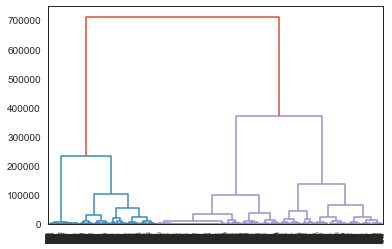

In [62]:
# data_cluster_x = ['Age', 'MotorValue_fillmean']
# data = data1[data_cluster_x]
# Z=linkage(data, method='ward',metric='euclidean')
# P=dendrogram(Z,0)

ValueError: x and y must have same first dimension, but have shapes (4,) and (3,)

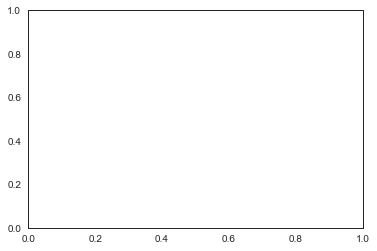

In [64]:
model=AgglomerativeClustering(n_clusters=5,linkage='ward')
 
model.fit(data)
r=pd.concat([data,pd.Series(model.labels_,index=data.index)],axis=1)
r.columns=list(data.columns)+['聚类类别']

style=['ro-','go-','bo-']
 
xlabels=['Age', 'MotorValue']
for i in range(5): 
    
    plt.figure()
    
    tmp=r[r[u'聚类类别']==i].iloc[:,:4] 
    
    for j in range(len(tmp)):
        
        plt.plot(range(1,5),tmp.iloc[j],style[i])
        
    plt.xticks(range(1,5),xlabels,rotation=20) 
    plt.subplots_adjust(bottom=0.15) 


# Application - Clustering

In [27]:
data_cluster_x = ['Age', 'MotorValue_fillmean']
data = data_score[data_cluster_x]

scaler = StandardScaler()
scaler.fit(data)
data = scaler.transform(data)

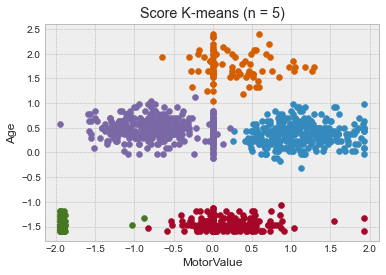

2480.67362803107


0.6643597163315229

In [29]:
cluster_model = KMeans(n_clusters=5, random_state=9)
cluster_model.fit(data)
yhat = cluster_model.predict(data)
clusters = unique(yhat)

clusters_id = [] # Store different cluster ids

for cluster in clusters:
    row_ix = where(yhat == cluster)
    clusters_id.append(row_ix[0])  
    plt.scatter(data[row_ix, 1], data[row_ix, 0])

plt.title('Score K-means (n = 5)')
plt.xlabel('MotorValue')
plt.ylabel('Age')

plt.show()

print(metrics.calinski_harabasz_score(data, yhat))
cluster_model.cluster_centers_

from sklearn.metrics import silhouette_score 
score = silhouette_score(data, yhat)
score

In [51]:
cluster_x = ['CreditCardType', 'Age', 'Gender', 'Location', 
             'MotorInsurance', 'MotorValue', 
             'HealthInsurance', 'TravelInsurance', 
#              'PrefChannel'
            ]

# data_score.iloc[clusters_id[0],][cluster_x].to_csv('data_test_cluster_1.csv', encoding='utf-8-sig') # cluster 1
# data_score.iloc[clusters_id[1],][cluster_x].to_csv('data_test_cluster_2.csv', encoding='utf-8-sig') # cluster 2
# data_score.iloc[clusters_id[2],][cluster_x].to_csv('data_test_cluster_3.csv', encoding='utf-8-sig') # cluster 3
# data_score.iloc[clusters_id[3],][cluster_x].to_csv('data_test_cluster_4.csv', encoding='utf-8-sig') # cluster 4
# data_score.iloc[clusters_id[4],][cluster_x].to_csv('data_test_cluster_5.csv', encoding='utf-8-sig') # cluster 5